In [1]:
pip install pandas unicode matplotlib seaborn scikit-learn plotly scipy 

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
pd.set_option("mode.copy_on_write", True)

# 1. Prepraracion para LOF

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load  data
combined_df = pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
features_to_scale= ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']

X = combined_df[features_to_scale]
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit_transform(X_scaled)

# Getting the cluster labels
labels = kmeans.labels_

# Adding the cluster labels to the original dataframe
combined_df['Cluster'] = labels

combined_df.head()

output_filepath = '../data/output/consumo_datamart_gold.csv'
combined_df.to_csv(output_filepath, index=False)

# 2. Calibracion del factor de Contaminacion

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

def silhouette_scorer(estimator, X, y=None):
    estimator.fit(X)
    preds = estimator.predict(X)
    if len(np.unique(preds)) > 1: 
        return silhouette_score(X, preds)
    else:
        return -1  


combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
data = combined_df[final_features].copy()
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
data_scaled_df = pd.DataFrame(data[final_features] , columns=final_features)
lof = LocalOutlierFactor(novelty=True)
# Fit the model
lof.fit(data_scaled_df)
param_grid = {
    'contamination': [ 0.05, 0.1, 0.25,  0.4, 0.5 ]
}

# Create RandomizedSearch  
random_search = RandomizedSearchCV(lof, param_distributions=param_grid,
                                   scoring=silhouette_scorer, cv=3, random_state=42)
# Perform random search
random_search.fit(data[features]) 
rint("Best parameters:", random_search.best_params_)
print("Best silhouette score: {:.2f}".format(random_search.best_score_))




c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Best parameters: {'contamination': 0.05}
Best silhouette score: 0.07


# 3. Calculo de outliers /score de anomalias y Robustez en la perspectiva global unidimensional

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

def get_anomalies_lof(df):
    df = df.copy()
       
    X = df
    
    #  LOF model
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
    
    # Fit the LOF model
    lof.fit(X)
    
    # Predict anomalies 
    preds = lof.predict(X)
    
    # Score anomalies 
    scores = lof.decision_function(X)  
    
    # Calculate the percentage of anomalies detected
    anomaly_count = (preds == -1).sum()  # Count the number of -1s in the predictions
    total = len(preds)  # Total number of data points
    anomaly_percentage = (anomaly_count / total) * 100  # Calculate the percentage
    print(f"Percentage of anomalies detected: {anomaly_percentage:.3f}%")

    # Add predictions back to the original DataFrame
    df['Anomaly'] = preds
    df['Anomaly_Score'] = scores
    
    return df


In [13]:
import pandas as pd


# Load the data
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']


time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df['Anomaly']= pd.NA
combined_df['Anomaly_Score_Global']= pd.NA
data = combined_df[final_features].copy()
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
data[final_features + ['Anomaly', 'Anomaly_Score_Global']]= get_anomalies_lof(data)
combined_df.update(data[['Anomaly','Anomaly_Score_Global']])

# Calculate and print the percentage of anomalies detected
anomaly_percentage = combined_df[combined_df['Anomaly'] == -1].shape[0] / combined_df.shape[0] * 100
print(f"Percentage of anomalies detected: {anomaly_percentage:.3f}%")

combined_df.rename(columns={'Anomaly':'Anomaly_Global'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.299%
Percentage of anomalies detected: 4.299%


In [14]:
# Group by 'ClienteId' and calculate the percentage of anomalies
anomaly_percentage_global = combined_df.groupby('ClienteId')['Anomaly_Global'].apply(
    lambda x: (x == -1.0).sum()*100/len(combined_df)
).reset_index(name='Porc_sospechosos_global')

anomaly_percentage_global

,ClienteId,Porc_sospechosos_global
0,1,0.064951
1,2,0.019205
2,3,0.085882
3,4,0.028915
4,5,0.411717
5,6,0.520473
6,7,0.278794
7,8,0.581971
8,9,0.197011
9,10,0.124292


# 4. Calculo de outliers/Score de Anomalia y Robustez del modelo desde la perspectiva por cliente

In [15]:

results = []
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df['Anomaly_Score_Cliente'] = pd.NA
combined_df['Anomaly'] = pd.NA

clients = sorted(list(combined_df['ClienteId'].unique()))
for idclient in sorted(clients):
    data = combined_df[combined_df['ClienteId'] == idclient].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    data =data[final_features]
    data[final_features + ['Anomaly','Anomaly_Score_Cliente' ]]=get_anomalies_lof(data)
    combined_df.update(data[['Anomaly','Anomaly_Score_Cliente']])
    anomalies_data = data[data['Anomaly'] == -1]
    # Calculate the percentage of anomalies detected
    anomaly_percentage_by_client = anomalies_data.shape[0]/data.shape[0]
   
    
    results.append((idclient,  anomaly_percentage_by_client * 100, 
                    combined_df[combined_df['ClienteId'] == idclient]['Sector_Economico'].iloc[0] ))
anomaly_percentages_by_client = pd.DataFrame(results, 
                                      columns=['ClienteId', 
                                               'Porc_sospechosos_cliente',
                                               'Sector_Economico'])

anomaly_percentages_by_client.sort_values(by='Porc_sospechosos_cliente', ascending=False)


combined_df.rename(columns={'Anomaly':'Anomaly_Cliente'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)
   

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.349%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.258%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.283%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.563%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.293%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.111%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.497%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.233%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.344%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.421%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.436%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.328%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.400%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.264%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.357%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.221%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.395%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.292%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.359%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.205%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.437%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.314%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.157%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.459%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.347%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.442%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.424%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.328%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.293%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.328%


# 5. Calculo de outliers/Score de Anomalia y Robustez del modelo desde la perspectiva por sector

In [16]:
results = []
sectors = sorted(list(combined_df['Sector_Economico'].unique()))
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
combined_df['Anomaly_Score_Sector'] = pd.NA
combined_df['Anomaly'] = pd.NA
anomaly_percentage_sector_consolidado= pd.DataFrame()
for sector in sectors:
    data_orig = combined_df[combined_df['Sector_Economico'] == sector]
    data = data_orig[final_features].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    data_orig[final_features + ['Anomaly','Anomaly_Score_Sector']]=get_anomalies_lof(data)
    combined_df.update(data_orig[['Anomaly','Anomaly_Score_Sector']])
    anomaly_percentage_sector = data_orig.groupby('ClienteId')['Anomaly'].apply(
        lambda x: (x == -1.0).sum()*100/len(data_orig)
    ).reset_index(name='Porc_sospechosos_sector')
    # Concatenate DataFrames
    anomaly_percentage_sector_consolidado = pd.concat([anomaly_percentage_sector_consolidado, 
                                                       anomaly_percentage_sector], ignore_index=True)


combined_df.rename(columns={'Anomaly':'Anomaly_Sector'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.348%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.321%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.111%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.296%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.400%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.309%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.384%


# 6. Recalibracion del factor de contaminancion en la perspectiva de Cluster. Queremos validar que el factor de contaminacion calibardo todavia es valido por cluster

In [10]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import LocalOutlierFactor

def silhouette_scorer(estimator, X, y=None):
    estimator.fit(X)
    preds = estimator.predict(X)
    if len(np.unique(preds)) > 1:  
        return silhouette_score(X, preds)
    else:
        return -1  



combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features

for cluster in range(0,4):
    data_orig = combined_df[combined_df['Cluster'] == cluster]
    data = data_orig[final_features].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])

    lof = LocalOutlierFactor(novelty=True)
   
    param_grid = {
        'contamination': [ 0.05, 0.1, 0.25,  0.4, 0.5 ]
    }


    # Create RandomizedSearch object 
    random_search = RandomizedSearchCV(lof, param_distributions=param_grid,
                                    scoring=silhouette_scorer, cv=3, random_state=42)
    # Perform random search
    random_search.fit(data[features]) 

    print(f"Best parameters For Cluster {cluster}:", random_search.best_params_)
    print(f"Best silhouette score For Cluster {cluster}:", "{:.2f}".format(random_search.best_score_))
    
    
    
    
    
    

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Best parameters For Cluster 0: {'contamination': 0.05}
Best silhouette score For Cluster 0: 0.09


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Best parameters For Cluster 1: {'contamination': 0.05}
Best silhouette score For Cluster 1: 0.11


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Best parameters For Cluster 2: {'contamination': 0.05}
Best silhouette score For Cluster 2: 0.18


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(

Best parameters For Cluster 3: {'contamination': 0.05}
Best silhouette score For Cluster 3: 0.08


# 7. Calculo de outliers/Score de anomalias desde la perspectiva de CLuster

In [17]:
results = []
sectors = sorted(list(combined_df['Sector_Economico'].unique()))
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
combined_df['Anomaly_Score_Cluster'] = pd.NA
combined_df['Anomaly'] = pd.NA
clusters = sorted(list(combined_df['Cluster'].unique()))
anomaly_percentage_cluster_consolidado= pd.DataFrame()
for cluster in clusters:
    data_orig = combined_df[combined_df['Cluster'] == cluster]
    data = data_orig[final_features].copy()
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    data_orig[final_features + ['Anomaly','Anomaly_Score_Cluster']]=get_anomalies_lof(data)
    combined_df.update(data_orig[['Anomaly','Anomaly_Score_Cluster']])
    anomaly_percentage_cluster = data_orig.groupby('ClienteId')['Anomaly'].apply(
        lambda x: (x == -1.0).sum()*100/len(data_orig)
    ).reset_index(name='Porc_sospechosos_cluster')
    anomaly_percentage_cluster['Cluster']=cluster
    
  
    # Concatenate DataFrames
    anomaly_percentage_cluster_consolidado = pd.concat([anomaly_percentage_cluster_consolidado, 
                                                       anomaly_percentage_cluster], ignore_index=True)
    
combined_df.rename(columns={'Anomaly':'Anomaly_Cluster'},inplace=True)

combined_df.to_csv('../data/output/consumo_datamart_gold.csv', index=False)






c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.425%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.372%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.373%


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Percentage of anomalies detected: 4.283%


In [18]:
merged_df = pd.merge(anomaly_percentage_global, 
                    anomaly_percentages_by_client, 
                     on='ClienteId', 
                     how='inner')
merged_df = pd.merge(merged_df, 
                    anomaly_percentage_sector_consolidado, 
                     on='ClienteId', 
                     how='inner')
merged_df = pd.merge(merged_df, 
                    anomaly_percentage_cluster_consolidado, 
                     on='ClienteId', 
                     how='inner')
merged_df.to_csv('../data/output/porcentaje_anomalias_consolidado.csv', index=False)


In [19]:
import pandas as pd
anomaly_percentage = pd.read_csv('../data/output/porcentaje_anomalias_consolidado.csv')


# Sort the DataFrame first by 'Sector_Economico' and then by 'Porc_sospechosos_sector' in descending order
sorted_df = anomaly_percentage.sort_values(by=['Sector_Economico', 'Porc_sospechosos_sector'], ascending=[True, False])

# Now display the sorted DataFrame
# If the DataFrame is very large, consider displaying only the top n rows per sector
for sector in sorted_df['Sector_Economico'].unique():
    print(f"---- {sector} ----")
    df= sorted_df[sorted_df['Sector_Economico'] == sector].drop_duplicates(subset=['ClienteId'])
    display(df)
    


---- captacion_tratamiento_distribucion_agua ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
54,18,0.050278,4.292308,captacion_tratamiento_distribucion_agua,1.320000,0.096779,0
51,17,0.023305,4.394872,captacion_tratamiento_distribucion_agua,1.229744,0.014279,0
48,16,0.046609,4.220513,captacion_tratamiento_distribucion_agua,0.781538,0.014279,0
60,20,0.113071,4.205128,captacion_tratamiento_distribucion_agua,0.607179,0.166587,0
57,19,0.024168,4.358974,captacion_tratamiento_distribucion_agua,0.409231,0.012692,0


---- cultivo_arboles_frutales_nueces ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
26,8,0.581971,4.232509,cultivo_arboles_frutales_nueces,1.479600,0.057116,0
18,6,0.520473,4.110563,cultivo_arboles_frutales_nueces,1.190996,0.244328,0
33,10,0.124292,4.420507,cultivo_arboles_frutales_nueces,0.911539,0.001587,0
22,7,0.278794,4.496723,cultivo_arboles_frutales_nueces,0.521315,0.007933,0
30,9,0.197011,4.344291,cultivo_arboles_frutales_nueces,0.217469,0.364906,0


---- cultivo_frutos_nueces_arboles_arbustos ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
46,15,0.019205,4.357143,cultivo_frutos_nueces_arboles_arbustos,1.683048,0.052356,0
44,14,0.051788,4.264286,cultivo_frutos_nueces_arboles_arbustos,1.027801,0.003173,0
39,12,0.068188,4.327639,cultivo_frutos_nueces_arboles_arbustos,0.949172,0.068221,0
37,11,0.037115,4.435714,cultivo_frutos_nueces_arboles_arbustos,0.451184,0.000000,0


---- cultivo_hortalizas ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
69,23,0.297135,4.156863,cultivo_hortalizas,1.725490,0.652070,0
66,22,0.228300,4.313725,cultivo_hortalizas,1.008403,0.456925,0
71,24,0.303825,4.459384,cultivo_hortalizas,0.658824,0.490243,0
63,21,0.121918,4.436975,cultivo_hortalizas,0.501961,0.269713,0
74,25,0.142418,4.347339,cultivo_hortalizas,0.401120,0.176107,0


---- cultivo_hortalizas_melones_raices_tuberculos ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
42,13,0.058693,4.4,cultivo_hortalizas_melones_raices_tuberculos,4.4,0.003173,0


---- elaboracion_cacao_chocolate_productos_confiteria ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
7,3,0.085882,4.283319,elaboracion_cacao_chocolate_productos_confiteria,1.314974,0.098366,0
14,5,0.411717,4.293481,elaboracion_cacao_chocolate_productos_confiteria,1.142218,0.206251,0
3,2,0.019205,4.257914,elaboracion_cacao_chocolate_productos_confiteria,0.807886,0.011106,0
0,1,0.064951,4.349372,elaboracion_cacao_chocolate_productos_confiteria,0.551801,0.058702,0
11,4,0.028915,4.562776,elaboracion_cacao_chocolate_productos_confiteria,0.491845,0.053943,0


---- venta_mayor_metales_minerales_metaliferos ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
90,30,0.068188,4.327639,venta_mayor_metales_minerales_metaliferos,1.282523,0.068221,0
83,28,0.102066,4.327639,venta_mayor_metales_minerales_metaliferos,1.229961,0.283992,0
87,29,0.124508,4.292597,venta_mayor_metales_minerales_metaliferos,0.835742,0.336348,0
79,27,0.065814,4.424004,venta_mayor_metales_minerales_metaliferos,0.825230,0.030144,0
76,26,0.039273,4.441524,venta_mayor_metales_minerales_metaliferos,0.210250,0.125337,0


In [18]:
import pandas as pd
anomaly_percentage = pd.read_csv('../data/output/porcentaje_anomalias_consolidado.csv')


# Sort the DataFrame first by 'Sector_Economico' and then by 'Porc_sospechosos_sector' in descending order
sorted_df = anomaly_percentage.sort_values(by=['Sector_Economico', 'Porc_sospechosos_sector'], ascending=[True, False])

# Now display the sorted DataFrame
# If the DataFrame is very large, consider displaying only the top n rows per sector
for cluster in sorted_df['Cluster'].unique():
    print(f"---- {cluster} ----")
    display(sorted_df[sorted_df['Cluster'] == cluster])

---- 0 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
54,18,0.015105,0.266667,captacion_tratamiento_distribucion_agua,0.034872,0.000000,0
57,19,0.005395,0.230769,captacion_tratamiento_distribucion_agua,0.022564,0.000000,0
51,17,0.000432,0.205128,captacion_tratamiento_distribucion_agua,0.021538,0.000000,0
60,20,0.010358,0.189744,captacion_tratamiento_distribucion_agua,0.012308,0.000000,0
48,16,0.001942,0.174359,captacion_tratamiento_distribucion_agua,0.008205,0.000000,0
30,9,0.029562,0.975560,cultivo_arboles_frutales_nueces,0.140237,0.061875,0
18,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.052356,0
22,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.001587,0
26,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.009519,0
33,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.000000,0


---- 1 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
55,18,0.015105,0.266667,captacion_tratamiento_distribucion_agua,0.034872,0.006703,1
58,19,0.005395,0.230769,captacion_tratamiento_distribucion_agua,0.022564,0.020108,1
52,17,0.000432,0.205128,captacion_tratamiento_distribucion_agua,0.021538,0.026811,1
61,20,0.010358,0.189744,captacion_tratamiento_distribucion_agua,0.012308,0.000000,1
49,16,0.001942,0.174359,captacion_tratamiento_distribucion_agua,0.008205,0.003351,1
19,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.072055,1
23,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.041892,1
27,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.065352,1
34,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.070379,1
40,12,0.000000,0.341656,cultivo_frutos_nueces_arboles_arbustos,0.073013,0.000000,1


---- 2 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
56,18,0.015105,0.266667,captacion_tratamiento_distribucion_agua,0.034872,0.000574,2
59,19,0.005395,0.230769,captacion_tratamiento_distribucion_agua,0.022564,0.000000,2
53,17,0.000432,0.205128,captacion_tratamiento_distribucion_agua,0.021538,0.000000,2
62,20,0.010358,0.189744,captacion_tratamiento_distribucion_agua,0.012308,0.034431,2
50,16,0.001942,0.174359,captacion_tratamiento_distribucion_agua,0.008205,0.000000,2
31,9,0.029562,0.975560,cultivo_arboles_frutales_nueces,0.140237,0.000574,2
20,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.013772,2
24,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.006312,2
28,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.008608,2
35,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.000000,2


---- 3 ----


,ClienteId,Porc_sospechosos_global,Porc_sospechosos_cliente,Sector_Economico,Porc_sospechosos_sector,Porc_sospechosos_cluster,Cluster
32,9,0.029562,0.975560,cultivo_arboles_frutales_nueces,0.140237,0.079901,3
21,6,0.026326,1.209288,cultivo_arboles_frutales_nueces,0.120929,0.053468,3
25,7,0.017479,0.436970,cultivo_arboles_frutales_nueces,0.080280,0.033042,3
29,8,0.010358,0.533509,cultivo_arboles_frutales_nueces,0.051827,0.021027,3
36,10,0.006905,0.675779,cultivo_arboles_frutales_nueces,0.028454,0.009612,3
41,12,0.000000,0.341656,cultivo_frutos_nueces_arboles_arbustos,0.073013,0.000000,3
68,22,0.001295,0.403361,cultivo_hortalizas,0.035854,0.000000,3
73,24,0.000000,0.436975,cultivo_hortalizas,0.013445,0.000000,3
65,21,0.000216,0.324930,cultivo_hortalizas,0.006723,0.000000,3
13,4,0.002158,0.401402,elaboracion_cacao_chocolate_productos_confiteria,0.045729,0.000000,3


# 7. Distribucion de score de anomalias por cada perspectiva

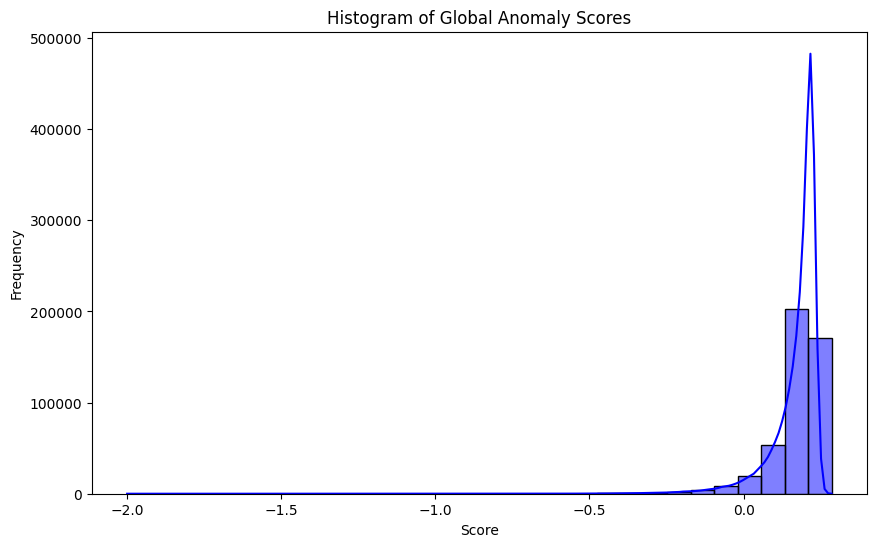

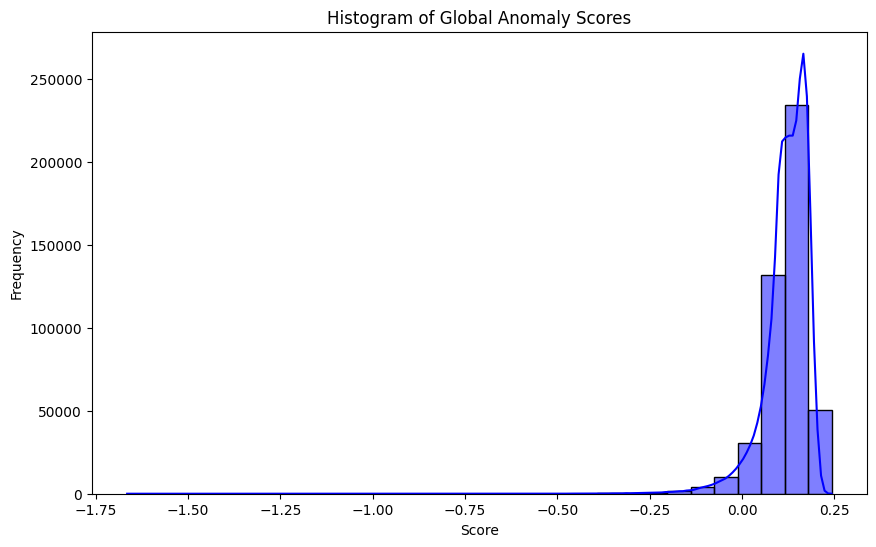

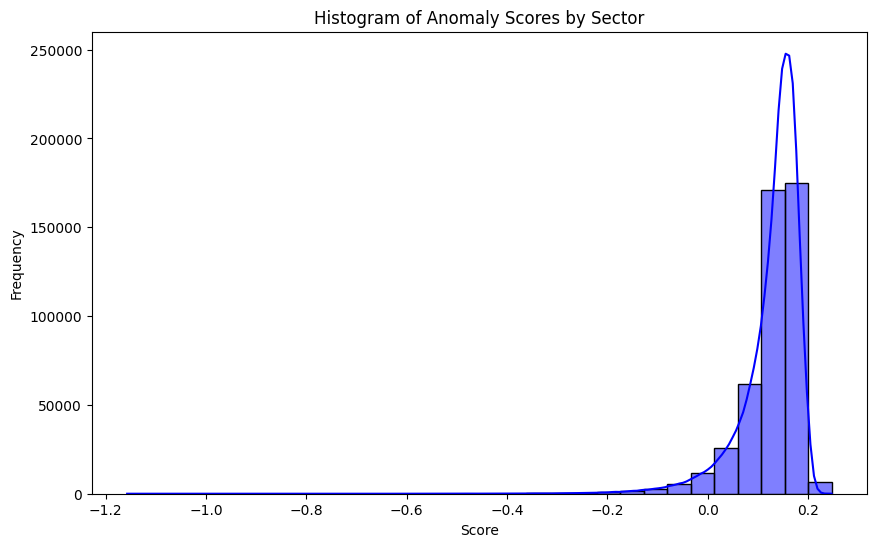

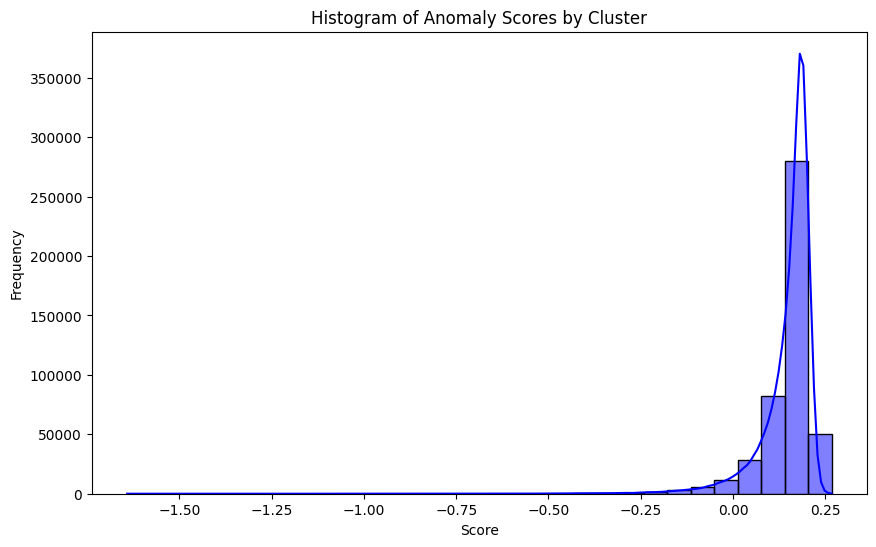

In [20]:

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Load the dataset
combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')


# Function to plot histograms
def plot_histogram(data, column, title, bins=30, color='blue'):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=True, color=color)
    plt.title(title)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

# Plotting histograms for each anomaly score
plot_histogram(combined_df, 'Anomaly_Score_Global', 'Histogram of Global Anomaly Scores')
plot_histogram(combined_df, 'Anomaly_Score_Cliente', 'Histogram of Global Anomaly Scores')
plot_histogram(combined_df, 'Anomaly_Score_Sector', 'Histogram of Anomaly Scores by Sector')
plot_histogram(combined_df, 'Anomaly_Score_Cluster', 'Histogram of Anomaly Scores by Cluster')


# 8. Plot de outliers en las cuatro variables de consumo

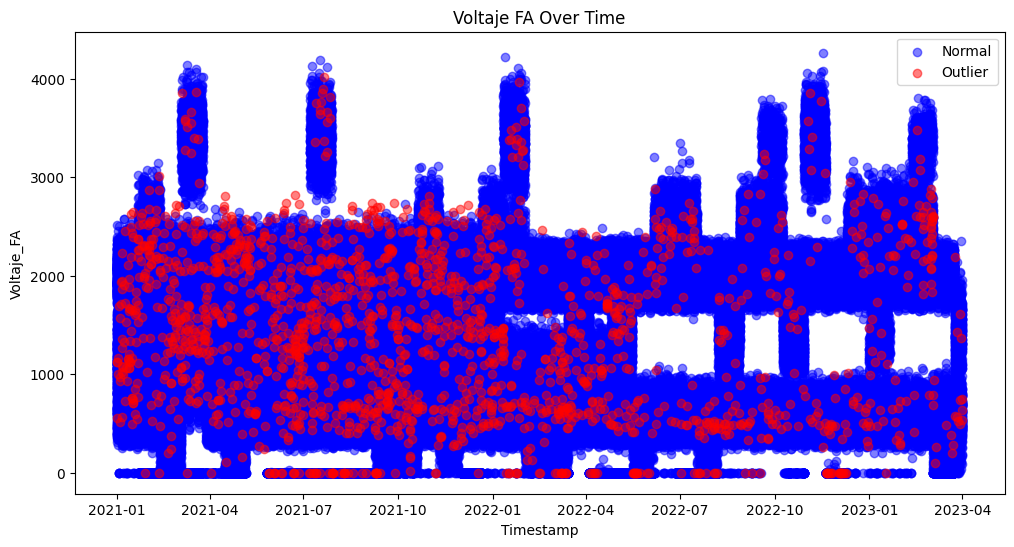

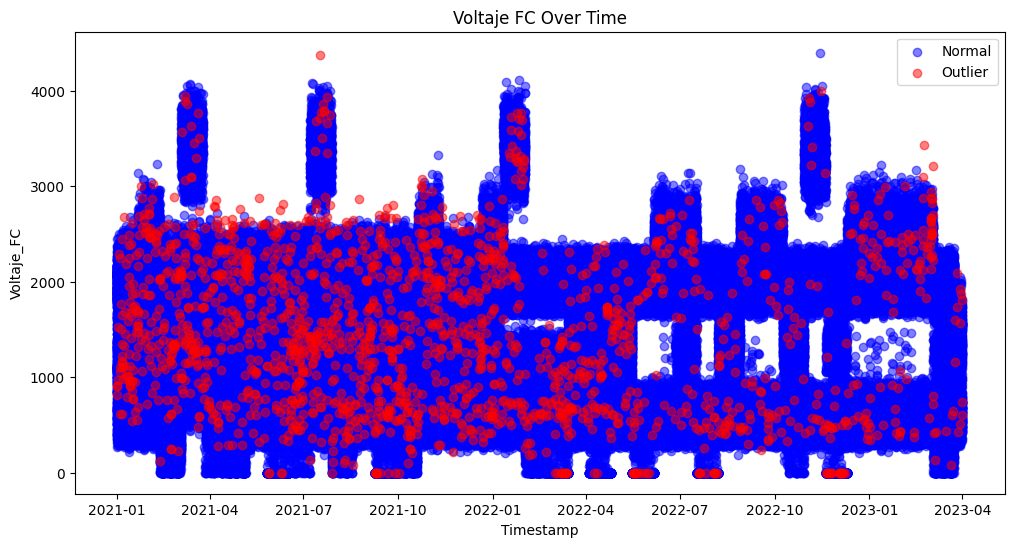

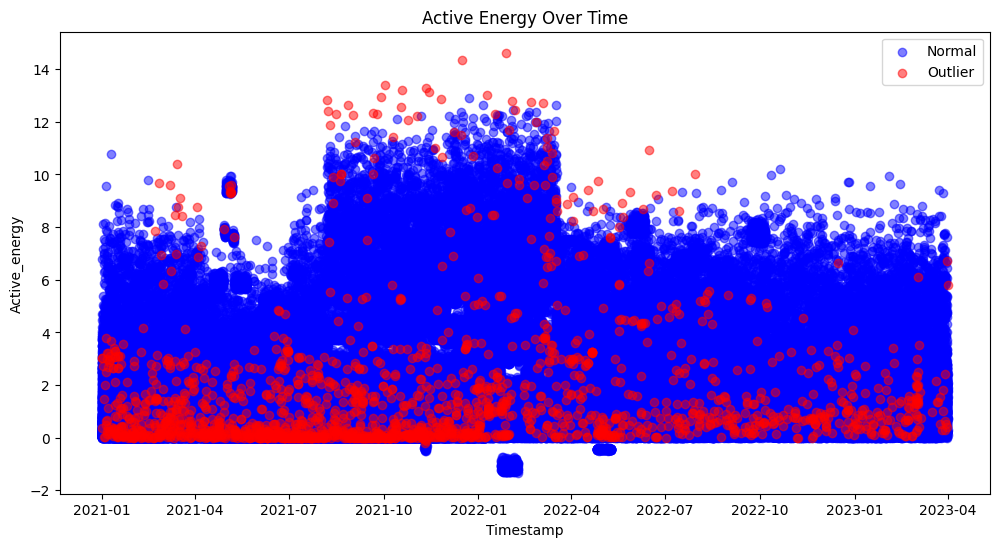

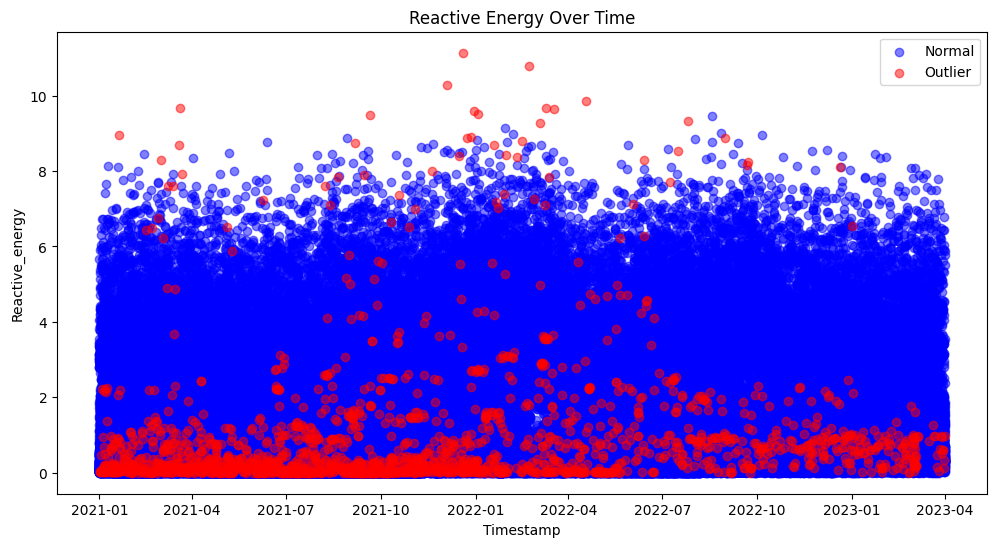

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Sub-sample 50% of the data
df_sampled = df.sample(frac=1)

# Define a function to determine if a row is an outlier
def is_outlier(row):
    if (row['Anomaly_Cluster'] == -1 and
        row['Anomaly_Sector'] == -1 and
        row['Anomaly_Cliente'] == -1 and
        row['Anomaly_Global'] == -1):
        return -1
    else:
        return 1

# Apply the function to each row
df_sampled['Outlier_Label'] = df_sampled.apply(is_outlier, axis=1)

# Function to create plots
def plot_data(df, x, y, hue, title):
    plt.figure(figsize=(12, 6))
    # Plot normal observations
    plt.scatter(df[x][df[hue] == 1], df[y][df[hue] == 1], c='blue', label='Normal', alpha=0.5)
    # Plot outliers
    plt.scatter(df[x][df[hue] == -1], df[y][df[hue] == -1], c='red', label='Outlier', alpha=0.5)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel(y)
    plt.legend()
    plt.show()

# Plotting data with the new Outlier_Label
plot_data(df_sampled, 'Fecha', 'Voltaje_FA', 'Outlier_Label', 'Voltaje FA Over Time')
plot_data(df_sampled, 'Fecha', 'Voltaje_FC', 'Outlier_Label', 'Voltaje FC Over Time')
plot_data(df_sampled, 'Fecha', 'Active_energy', 'Outlier_Label', 'Active Energy Over Time')
plot_data(df_sampled, 'Fecha', 'Reactive_energy', 'Outlier_Label', 'Reactive Energy Over Time')


# 9. Experimento para saber si tenemos varis niveles de contaminacion, buscar las observaciones que se encuentran en todos los factores de contaminaicon como oultiers

In [23]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV



combined_df = pd.read_csv('../data/output/consumo_datamart_gold.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
time_features= ['Dia_Sin', 'Dia_Cos','Hora_Sin','Hora_Cos','Mes_Sin','Mes_Cos']
final_features= features + time_features
scaler = StandardScaler()
combined_df[features] = scaler.fit_transform(combined_df[features])


# Range of contamination factors to test.
contamination_factors = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
outliers_detected = {}  # Dictionary to store the indices of outliers for each contamination factor

for cont in contamination_factors:

    lof = LocalOutlierFactor(n_neighbors=20, contamination=cont, novelty=True)
    # Fit the model
    lof.fit(combined_df[final_features])
    
    # Predict the outliers (-1 for outliers, 1 for inliers)
    predictions = lof.predict(combined_df[final_features])
    
    # Get the indices of outliers
    outlier_indices = np.where(predictions == -1)[0]
    
    # Store the outlier indices in the dictionary
    outliers_detected[cont] = set(outlier_indices)

# Compare the outlier detections across the different contamination factors
# This will find the intersection of outlier indices across all contamination factors
consistent_outliers = set.intersection(*outliers_detected.values())

# Convert the set of consistent outliers to a list if needed
consistent_outliers_list = list(consistent_outliers)

# Print the results
print(f"Consistent outliers detected across all contamination factors: {consistent_outliers_list}")








c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\final_project\source\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\HP\OneDrive\Documents\Eduardo Toledo\MIAD\f

Consistent outliers detected across all contamination factors: [450560, 393220, 393221, 286727, 417802, 393227, 229388, 385037, 450570, 450576, 368657, 245778, 393235, 417809, 368661, 417813, 450578, 393243, 393244, 245790, 450593, 8228, 376871, 393256, 450604, 237623, 393271, 450615, 245818, 393275, 245820, 401470, 245823, 401473, 245829, 237639, 245835, 237644, 245839, 385104, 442449, 368724, 16469, 368727, 450647, 368733, 319586, 385122, 393315, 32870, 385127, 385130, 393324, 245869, 319598, 385138, 344181, 368758, 417909, 426104, 426105, 32889, 426102, 426108, 385149, 450686, 434302, 401537, 450692, 417929, 426121, 426126, 376977, 57490, 417937, 417939, 426133, 426135, 393369, 98458, 213147, 417946, 385181, 426137, 393376, 417953, 237732, 393381, 426148, 450725, 426152, 213162, 237740, 237741, 385198, 417965, 426161, 417970, 426165, 409783, 450743, 32957, 32959, 237759, 237761, 245951, 237763, 393409, 426175, 426176, 426178, 426179, 245963, 393421, 377040, 418002, 426194, 442578, 2

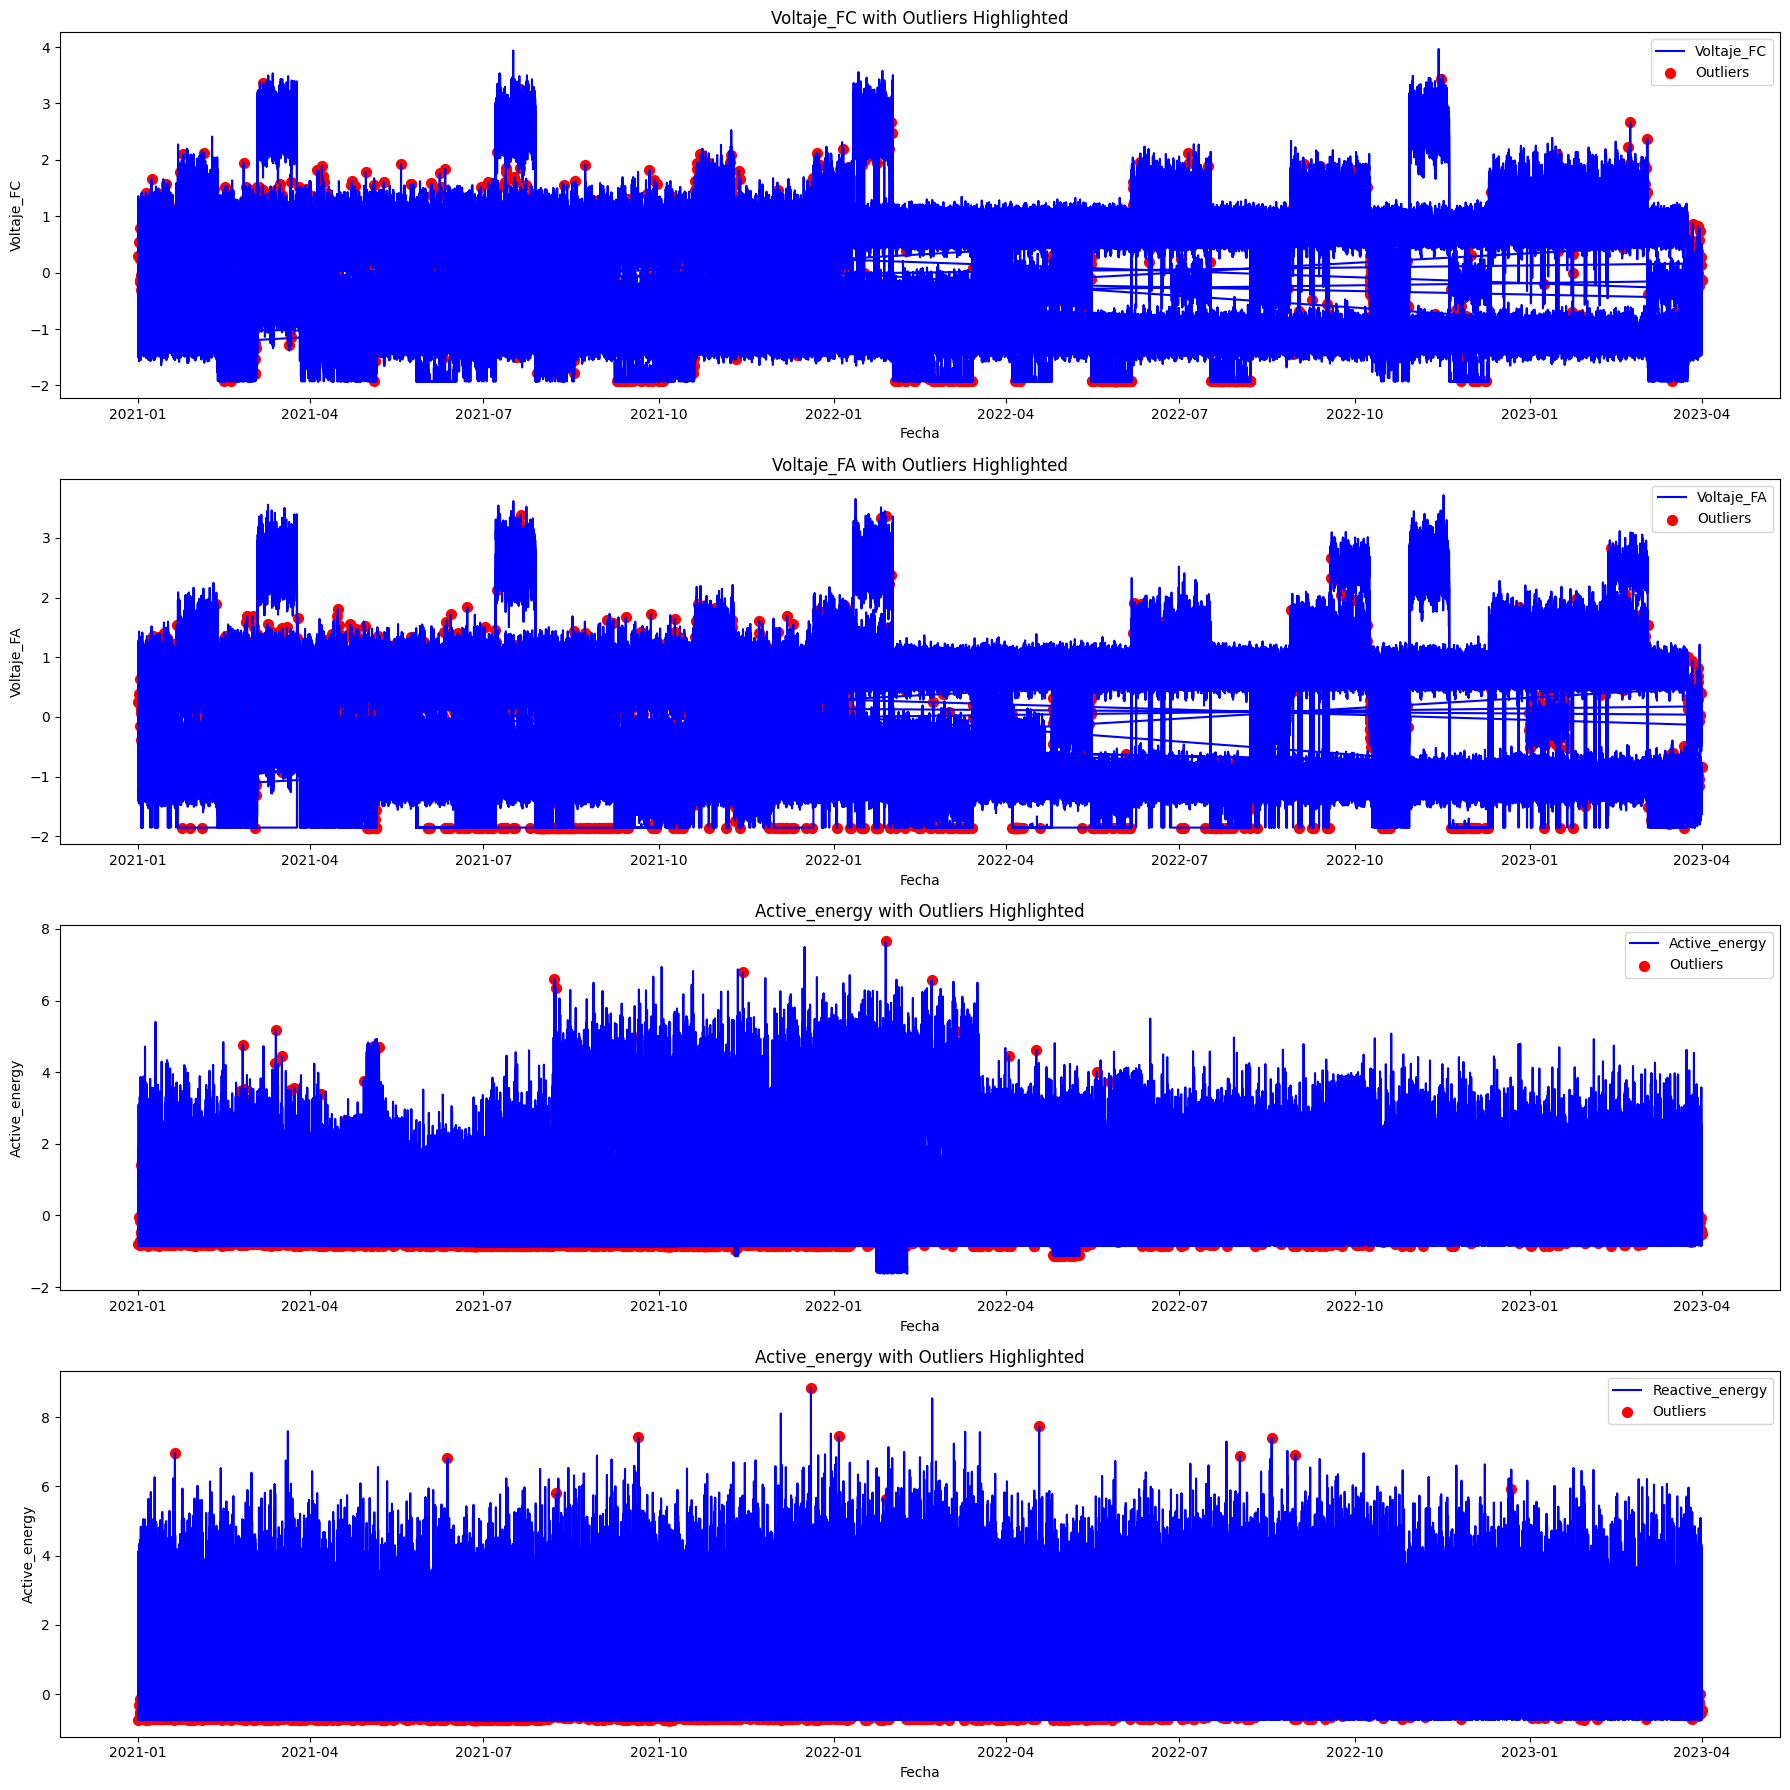

In [24]:
import matplotlib.pyplot as plt
import pandas as pd


#  'consistent_outliers_list' contains the indices of consistent outliers

# Convert 'Fecha' to datetime if it's not already
combined_df['Fecha'] = pd.to_datetime(combined_df['Fecha'])

# Create a figure with two subplots, one for each voltage measurement
fig, axs = plt.subplots(4, 1, figsize=(18, 18))  # 2 rows, 1 column

# Plot for Voltaje_FC
axs[0].plot(combined_df['Fecha'], combined_df['Voltaje_FC'], 'b-', label='Voltaje_FC', markersize=5)
axs[0].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Voltaje_FC'], color='red', s=50, label='Outliers')
axs[0].set_title('Voltaje_FC with Outliers Highlighted')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Voltaje_FC')
axs[0].legend()

# Plot for Voltaje_FA
axs[1].plot(combined_df['Fecha'], combined_df['Voltaje_FA'], 'b-', label='Voltaje_FA', markersize=5)
axs[1].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Voltaje_FA'], color='red', s=50, label='Outliers')
axs[1].set_title('Voltaje_FA with Outliers Highlighted')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Voltaje_FA')
axs[1].legend()

# Plot for Voltaje_FA
axs[2].plot(combined_df['Fecha'], combined_df['Active_energy'], 'b-', label='Active_energy', markersize=5)
axs[2].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Active_energy'], color='red', s=50, label='Outliers')
axs[2].set_title('Active_energy with Outliers Highlighted')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Active_energy')
axs[2].legend()

axs[3].plot(combined_df['Fecha'], combined_df['Reactive_energy'], 'b-', label='Reactive_energy', markersize=5)
axs[3].scatter(combined_df.loc[consistent_outliers_list, 'Fecha'], combined_df.loc[consistent_outliers_list, 'Reactive_energy'], color='red', s=50, label='Outliers')
axs[3].set_title('Active_energy with Outliers Highlighted')
axs[3].set_xlabel('Fecha')
axs[3].set_ylabel('Active_energy')
axs[3].legend()

# Adjust the layout of the plot to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
